## Logistic Regression from Fraud Prediction
It is inspired by https://www.kaggle.com/dstuerzer/optimized-logistic-regression

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import itertools


In [45]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    """Plot confusion matrix
       Normalization=False by default"""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1[:, np.newaxis])
        
    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color = 'white' if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel("Actural")
    plt.xlabel("Predicted")
    plt.show()

def show_data(cm, print_metrics = 0):
    tp = cm[1,1]    ## true positive
    fn = cm[1,0]    ## false negative
    fp = cm[0,1]    ## false positive
    tn = cm[0,0]    ## true negative
    if print_metrics == 1:
        print("tp = {:d}".format(tp))
        print("tn = {:d}".format(tn))
        print("fp = {:d}".format(fp))
        print("fn = {:d}".format(fn))
        print()
        print("Precision = {:.3f}".format(tp/(tp+fp)))
        print("Recall (True Positive Rate, or TPR) = {:.3f}".format(tp/(tp+fn)))
        print("Fallout (False Positive Rate, or FPR) = {:.6f}".format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)
   

In [46]:
df = pd.read_csv("./input/creditcard.csv")
print(df.head(3))

y = np.array(df.Class.tolist()) ## Classes: 1 fraud, 0 genuine
df = df.drop("Class", 1)
df = df.drop("Time", 1)

df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

X = np.array(df.as_matrix())   ## features



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]


In [47]:
print("Fraction of fraud: {:.5f}".format(np.sum(y)/len(y)))

Fraction of fraud: 0.00173


### Split the data into training and testing data set

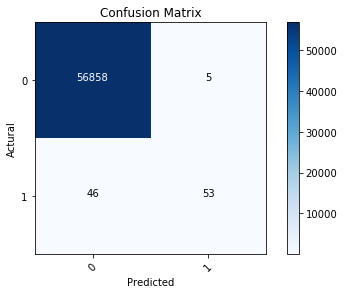

tp = 53
tn = 56858
fp = 5
fn = 46

Precision = 0.914
Recall (True Positive Rate, or TPR) = 0.535
Fallout (False Positive Rate, or FPR) = 0.000088


In [48]:
logReg = LogisticRegression()

strKfold = StratifiedKFold(n_splits = 5, shuffle = True)
for train_index, test_index in strKfold.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break
    
logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
if logReg.classes_[0] == 1:
    cm = np.array([ [ cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]       ]  ])

plot_confusion_matrix(cm, ['0', '1'], )
posRate, truePosRate, falsePosRate = show_data(cm, print_metrics = 1);
    

- The **Precision** denotes the probability that a transaction is classified as fraud is truly a fraud.
- The **Recall** (True Positive Rate, or TPR) is the probability that a true fraud is recognized by the classifier.
- The **Fallout** (False Positive Rate, or FPR) is the probability that a non-fraud is wrongly classified as a fraud.

The rule of thumb:  
- Precision should be close to one. If precision is low, the transaction from genuine customer will be considered as a fraud.
- Recall should be close to one. We want to detect fraud with a high probability. Practically, 80% is very good.
- Fallout should be very low. Customers don't want to frequently receive a fraud alert.


## Optimize the model  
- weight of the class  
- probability threshold  

Essentially, the logistic regression returns probability into the predicted classes, and the prediction is classified by the selected threshold. By changing the threshold, we could determine the model to be more sensitive (but it increases wrong detection), or less restrictive (and miss more frauds).

ROC --> StraitifiedKFold --> (repeat) --> average.


In [59]:
## cross_validation for given parameters, c and r.
## return average TPR and FPR
def ROC(X, y, c, r):
    dic_weight = {1:len(y)/(r*np.sum(y)), 0:len(y)/(len(y)-r*np.sum(y))}
    logReg = LogisticRegression(penalty = 'l2',
                                 C = c,
                                 class_weight = dic_weight)
    N_KFold = 5
    N_repeating_step = 3
    mean_truePosRate = 0.0
    mean_threshold = 0.0
    mean_falsePosRate = np.linspace(0, 1, 100)
    
    for iteration in range(N_repeating_step):
        strKFold = StratifiedKFold(n_splits = N_KFold, shuffle = True)
        for train_index, test_index in strKfold.split(X, y):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
            logReg.fit(X_train, y_train)
            y_prob = logReg.predict_proba(X_test)[:, logReg.classes_[1]]
            
            falsePosRate, truePosRate, threshold = roc_curve(y_test, y_prob)
            mean_truePosRate += np.interp(mean_falsePosRate, falsePosRate, truePosRate)
            mean_threshold += np.interp(mean_falsePosRate, falsePosRate, threshold)
            mean_truePosRate[0] = 0.0
    
    mean_truePosRate /= (N_KFold*N_repeating_step)s
    mean_truePosRate[-1] = 1.0
    return mean_falsePosRate, mean_truePosRate, roc_auc_score(y_test, y_prob), mean_threshold 

### Evaluate parameter C

In [60]:
def plot_roc(X, y, list_par_1, par_1 = 'C', par_2 = 1):
    f = plt.figure(figsize = (12, 8));
    for p in list_par_1:
        if par_1 == 'C':
            c = p
            r = par_2
        else:
            r = p
            c = par_2
        list_FP, list_TP, AUC, mean_threshold = ROC(X, y, c, r)
        plt.plot(list_FP, list_TP, label = 'C = {}, r = {}, TPR = {:6f}, \
                 AUC = {:.4f}'.format(c, r, list_TP[10], AUC))
    plt.legend(title= 'values', loc= 'lower right')
    plt.xlim(0, 0.001)
    plt.ylim(0.5, 0.9)
    plt.xlabel('FalsePositiveRate')
    plt.ylabel('TruePositiveRate')
    plt.title('ROC detail')
    plt.axvline(3e-4, color='b', linestyle='dashed', linewidth=2)
    plt.show()
    plt.close()

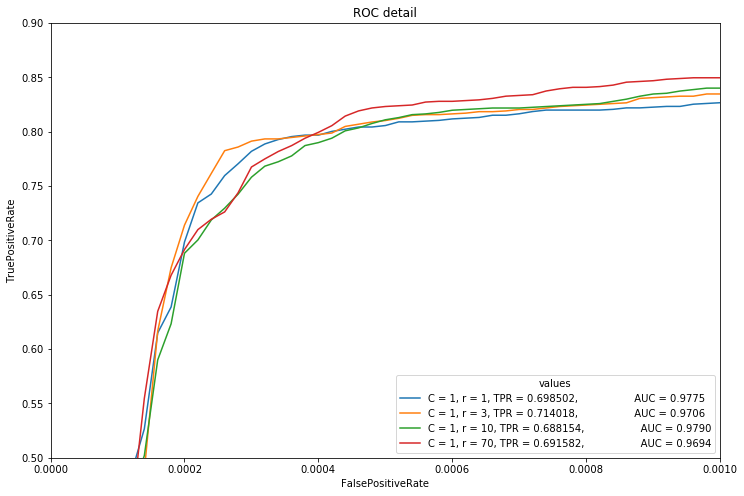

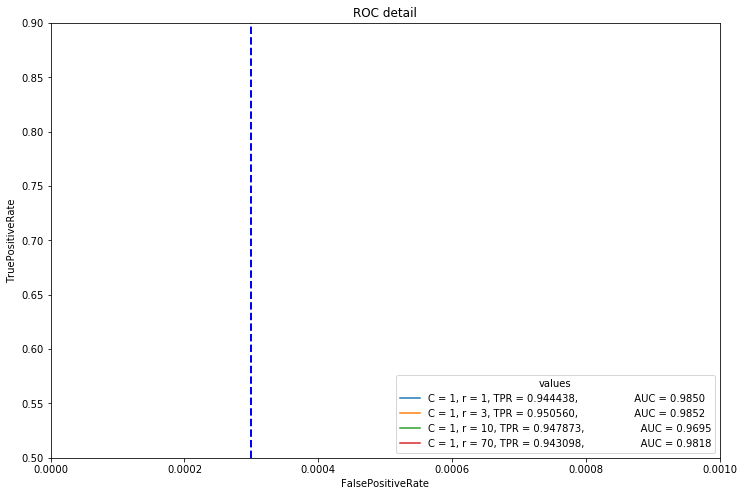

In [61]:
plot_roc(X, y, [1, 3, 10, 70], 'r', 1)

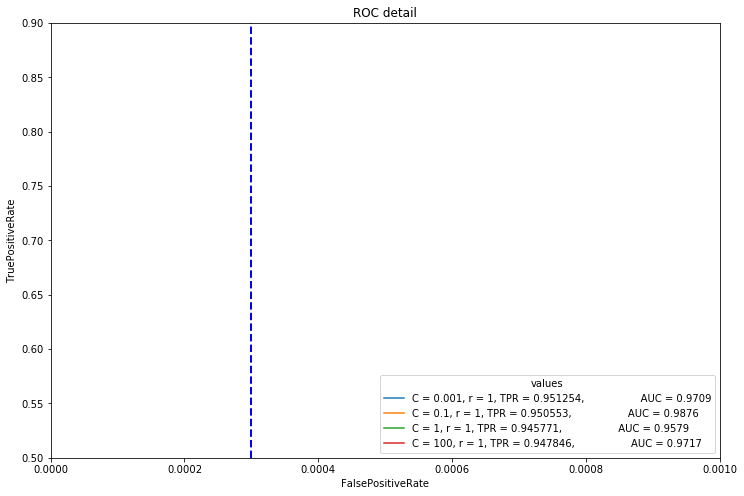

In [62]:
plot_roc(X,y, [0.001, 0.1, 1, 100], 'C', 1) 

### Determine the threshold

In [70]:
N_threshold = np.arange(10,80,2)     # will define threshold [10 12 ... 76 78]

## initialize
cm = {}
for n in N:
    cm[n] = 0.0
    
logRegression = LogisticRegression(penalty = 'l2', C = 1, class_weight = 'balanced')
## class_weight "balanced" means r = 1

N_Kfold = 5
N_iter = 3
for iteration in range(N_iter):
    StrKFold = StratifiedKFold(n_splits = N_Kfold, shuffle = True)
    for train_index, test_index in StrKFold.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        logRegression.fit(X_train, y_train)
        y_prob = logRegression.predict_proba(X_test)[:, logRegression.classes_[1] ]
    
        for n in N_threshold:
            threshold = 1 - np.power(10., -(n/10))
            y_pred = np.zeros(len(y_prob))
            for j in range(len(y_prob)):
                if y_prob[j] > threshold:
                    y_pred[j] = 1
            
            B = confusion_matrix(y_test, y_pred)
            
            if logRegression.classes_[0] == 1:
                B = np.array([ [B[1,1], B[1,0]],
                               [B[0,1], B[0,0]]
                             ])
            cm[n] += B

for n in N_threshold:
    cm[n] = cm[n] //(N_Kfold*N_iter)
        
        
     

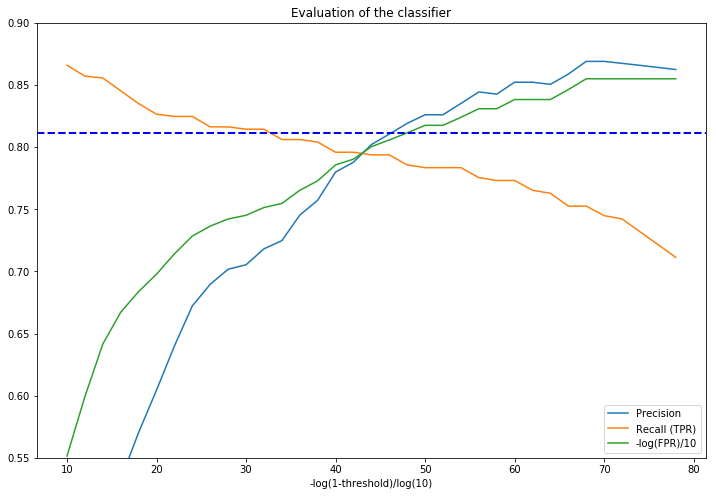

In [72]:
PR = []   ## Precision
TPR = []  ## True Positive Rate
FPR = []  ## False Positive Rate
Threshold = N_threshold
for n in N_threshold:
    pr, tpr, fpr = show_data(cm[n])
    PR.append(pr)
    TPR.append(tpr)
    FPR.append(-np.log(fpr)/10)
    
g  = plt.figure(figsize = (12,8))   
plt.plot(Threshold, PR, label = 'Precision')
plt.plot(Threshold, TPR, label = 'Recall (TPR)')
plt.plot(Threshold, FPR, label = '-log(FPR)/10')
plt.axhline(-np.log(3e-4)/10, color='b', linestyle='dashed', linewidth=2)
plt.title('Evaluation of the classifier')
plt.legend( loc='lower right')
plt.xlabel('-log(1-threshold)/log(10)')
plt.ylim(0.55,0.9)
plt.show()

### Case Study
**Case 1:** False Positive Rate < 3e-4


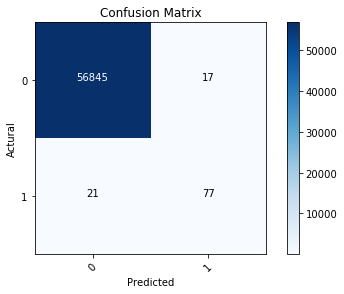

tp = 77
tn = 56845
fp = 17
fn = 21

Precision = 0.819
Recall (True Positive Rate, or TPR) = 0.786
Fallout (False Positive Rate, or FPR) = 0.000299


In [73]:
i = 0
while FPR[i] < -np.log(3e-4)/10:
    i += 1
A = cm[Threshold[i]].astype(int)
plot_confusion_matrix(A, ['0', '1'])
show_data(A, print_res = 1);

### Reflection  
In practice, the other factors should be taken into account so that one could obtain the desired results. The business insight comes to play a role here.